In [1]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline
from matplotlib.ticker import NullFormatter
import chardet
from scipy.optimize import curve_fit

from sklearn import metrics

# from sklearn import metrics
# import Data_Processor as DP
# import importlib
# importlib.reload(DP)

Root = 'C:/Illisarvik/'
# print(CD.loc[CD.index.get_level_values('Collar')=='veg',[Flux,'DOY']].groupby('DOY').count())
# print(CD.loc[(CD['DOY']== 208)&(CD.index.get_level_values('Collar')=='unveg'),[Flux,'Site']])

# W = np.asanyarray([.5,.5,.5,.4])

print((1/10)**.5,(1/56)**.5,(1/56+1/56)**.5,(1/56+1/10)**.5)

0.31622776601683794 0.1336306209562122 0.1889822365046136 0.34330328116279757


0.93374
0.968629
  Flux      Scale  Estimates  95% CI/PI        SE Interval Type          N  \
0   ER  Footprint   4.367188   0.844234  0.423816            CI  75.276196   
1   ER      Basin   4.008449   0.840870  0.421306            CI  67.263551   
2  NME  Footprint  13.630093   7.968323  4.000197            CI  75.276196   
3  NME      Basin  14.968051   8.644676  4.331294            CI  67.263551   

           Type  
0  Chamber Obs.  
1  Chamber Obs.  
2  Chamber Obs.  
3  Chamber Obs.  
C:\Users\wesle\Illisarvik_Processing


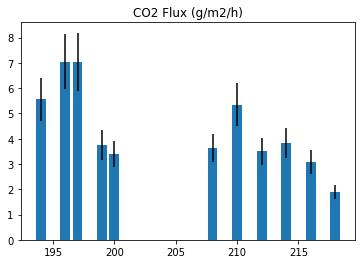

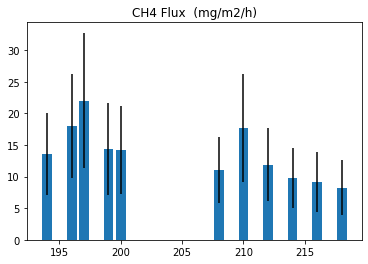

In [2]:
Names={'T12' : 'Tundra',
       'B6' : 'Peat Plateau',
       'C3' : 'Low Willow',
       'E2' : 'Dense Willow',
       'F8' : 'Tall Willow',
       'E7' : 'Cotton Grass',
       'F3' : 'Wet Sedge 1',
       'H6' : 'Wet Sedge 2',
       'H7' : 'Grass',
       'J6' : 'Bare Ground'}

with open(Root+'ChamberData.csv', 'rb') as f:
    result = chardet.detect(f.read())
#     print(result['encoding'])
    
CD=pd.read_csv(Root+'ChamberData.csv',header=0,parse_dates={'datetime':[1,2]},
               index_col=['Class','Collar','datetime'],encoding=result['encoding'])

CD['SiteName'] = ' '
CD['DOY'] = CD.index.get_level_values('datetime').dayofyear.values


CD['CH4 Flux  (mg/m2/h)'] = CD['CH4 Flux  (nmol/m2/s)']*1e-6 * 3600 * 12.0107# 16.04246

CD['CO2 Flux (g/m2/h)'] = CD['CO2 Flux (umol/m2/s)']*1e-6 * 3600  * 12.0107# 44.0095
# print(CD['CO2 Flux (g/m2/s)'], CD['CO2 Flux (umol/m2/s)'])
level_values = CD.index.get_level_values
CDMean = CD.groupby([level_values(i) for i in [0,1]]).mean()
CDMedian = CD.groupby([level_values(i) for i in [0,1]]).median()
CDC = CD.groupby([level_values(i) for i in [0,1]]).count()
CDStd = CD.groupby([level_values(i) for i in [0,1]]).std()#**2#*stats.t.ppf(1-0.025,CDC)
# CDStd = CDStd/CDC**.5*stats.t.ppf(1-0.025,CDC)
CDmax = CD.groupby([level_values(i) for i in [0,1]]).max()
CDmin = CD.groupby([level_values(i) for i in [0,1]]).min()


Upland =   0.062524
Sedge  =   0.108134
Sparse =   0.022291
Grass  =   0.375453
Shrub  =   0.365338


FPArea = np.asanyarray([0.022291,0.375453,0.365338,0.108134,0.062524])
# FPArea = np.asanyarray([0,0.279263,0.482874,0.122590,0])
print(FPArea.sum())
FPArea/=FPArea.sum()
# NightFPArea = np.asanyarray([0.049552,0.355210,0.354524,0.112935,0.061909])
BasinArea = np.asanyarray([0.083902,0.279263,0.482874,0.122590,0])
print(BasinArea.sum())
BasinArea/=BasinArea.sum()


Key = np.asanyarray(['Sparse','Grass','Shrub','Sedge','Upland'])
Fractions={}
Fractions['area']={}
Fractions['CH4 Flux  (nmol/m2/s)']={}
Fractions['CO2 Flux (umol/m2/s)']={}
CDT = CD
i = 0
# outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.1)
Estimates = []
CIs = []
Std = []
Scale = []
Samples = []
Fluxes = []

Akey = {}
for Flux,i in zip(['CO2 Flux (g/m2/h)','CH4 Flux  (mg/m2/h)'],[0,1]):
    for Area,Name in zip([FPArea,BasinArea],['FPArea','BasinArea']):
        Akey[Name]={}
        if Flux[:3] == 'CO2':
            Fluxes.append('ER')
        else:
            Fluxes.append('NME')
        for area,key in zip(Area,Key):
            Fractions['area'][key] = area
            Akey[Name][key]=area

        Fractions['CH4 Flux  (mg/m2/h)']=Area*0
        Fractions['CO2 Flux (g/m2/h)']=Area*0
#         print()
        if Name == 'FPArea':
            Scale.append('Footprint')
        else:
            Scale.append('Basin')
#         print(Name)

        M = CDMean[Flux].unstack()#.reset_index()
        C = CDC[Flux].unstack()#.reset_index()
        S = CDStd[Flux].unstack()#.reset_index()
        M = M['veg'].fillna(M['unveg'])
        C = C['veg'].fillna(C['unveg'])
        S = S['veg'].fillna(S['unveg'])
        if Name == 'BasinArea':
            M = M.loc[M.index!='Upland']
            C = C.loc[C.index!='Upland']
            S = S.loc[S.index!='Upland']
        mult = 24
        Temp = CD.loc[(CD.index.get_level_values('Collar') =='veg'),[Flux,'Site']].reset_index((0,1))#'datetime')
        TOmp = CD.loc[((CD.index.get_level_values('Collar') =='unveg')&(\
                       CD.index.get_level_values('Class') =='Sparse')),[Flux,'Site']].reset_index((0,1))#'datetime')
        Temp = Temp.append(TOmp)
#         print(TOmp)
        for key,val in Fractions['area'].items():
            try:
                Temp.loc[Temp['Class']==key,'W']=val
            except:
                Temp.loc[Temp['Class']==key,'W']=val*0

        Temp.index = pd.to_datetime(Temp.index)

        TImp = (Temp.groupby([Temp.Class,Temp.index.dayofyear]).mean().reset_index(0))
        TImpC = (Temp.groupby([Temp.Class,Temp.index.dayofyear]).count().reset_index(0))
        TImp['Count'] = TImpC[Flux]
        TImp['Weighted'] = TImp[Flux]*TImp['W']
        TImp['WeightedStd'] = TImp[Flux]*TImp['W']
        for i in TImp.index.unique():
            TYmp = Temp.loc[Temp.index.dayofyear==i]
            W = TImp.loc[TImp.index == i,'Weighted'].mean()
            V = (Temp.loc[Temp.index.dayofyear==i,'W']*(Temp.loc[Temp.index.dayofyear==i,Flux] - W)**2).sum()\
            /Temp.loc[Temp.index.dayofyear==i,'W'].sum()
            
            TImp.loc[TImp.index == i,'WeightedStd']=V**.5
            TImp.loc[TImp.index == i,'Count']=TYmp['W'].sum()**2/(TYmp['W']**2).sum()

        TAmp = TImp.groupby(TImp.index).sum()
        TAmp[['Count','WeightedStd']] = TImp.groupby(TImp.index)[['Count','WeightedStd']].first()
        N=int(TAmp['Count'].sum())
        Estimates.append(TAmp['Weighted'].mean()*24)
        
        Ux = TAmp['Weighted'].mean()
        P1 = ((TAmp['Count']-1)*TAmp['WeightedStd']**2+TAmp['Count']*Ux**2).sum()
        P2 = TAmp['Count'].sum()*Ux**2
        VarX = 1/(TAmp['Count'].sum()-1)*(P1-P2)
        Sp = VarX**.5*24
        
#         print(Sp,(TAmp['WeightedStd']**2).mean()**.5)
        for N in [TAmp['Count'].sum(),C.min()]:
#             print('N ',N)
#             print('A',
#                   (Sp*(1/11)**.5*stats.t.ppf(1-0.025,11)*24/Sp)/((1/56)**.5*stats.t.ppf(1-0.025,56)*24))
#             print('Weighted 95% : ',Sp*(1/N)**.5*stats.t.ppf(1-0.025,N)*24)
            if N > 11:
                Std.append(Sp/(N**.5))
                CIs.append(Sp*(1/N)**.5*stats.t.ppf(1-0.025,N))
                Samples.append(N)
        
        
        if Name == 'FPArea':
            plt.figure()
            plt.title(Flux)
            plt.bar(TAmp.index,TAmp['Weighted']*24,
                    yerr=(TAmp['WeightedStd']**2*24)**.5/TAmp['Count']**.5*stats.t.ppf(1-0.025,TAmp['Count']))
            
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':Std,'Interval Type':'CI','N':Samples,
       'Type':'Chamber Obs.'}
Res = pd.DataFrame(data = Data)
print(Res)
import os
print(os.getcwd())
Res.to_csv('ScaledChamberFluxes.csv')
# plt.figure()
# print(CDMean)#['AirTemp'])


CO2 Flux (g/m2/h)       4.367188
CH4 Flux  (mg/m2/h)    13.630093
dtype: float64
CO2 Flux (g/m2/h)       4.008449
CH4 Flux  (mg/m2/h)    14.968051
dtype: float64
74    16
75    17
76    10
77    14
78    10
79    16
80     9
81    10
82    10
83    10
84     9
85    10
86    13
87    14
88    10
89    13
90    10
91    11
92     9
93    14
94     9
95     9
Name: datetime, dtype: int64


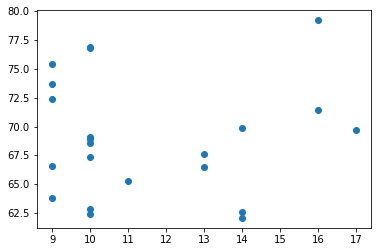

In [3]:
# Bukey = CD.reset_index([0,1])


for scale in ['FPArea','BasinArea']:
    Temp = CDMean.reset_index()
    Fluxes = Temp.loc[(Temp['Collar']=='veg')|((Temp['Collar']=='unveg')&(Temp['Class']=='Sparse')),['Class','CO2 Flux (g/m2/h)','CH4 Flux  (mg/m2/h)']]

    for f in Fluxes['Class']:
        Fluxes.loc[Fluxes['Class']==f,['CO2 Flux (g/m2/h)','CH4 Flux  (mg/m2/h)']]*=Akey[scale][f]
    print(Fluxes[['CO2 Flux (g/m2/h)','CH4 Flux  (mg/m2/h)']].sum()*24)#['W'])
# # # Bukey
# Tukey = Bukey.loc[(Bukey['Class']=='Sedge')&(Bukey['Collar']=='veg')]#.sort_values(by='datetime')
# Tukey = Tukey.groupby('DOY').mean()
# plt.figure()
# plt.plot(Tukey['VWC'])
# x2 = plt.twinx()
# x2.plot(Tukey['soil temp'],color='red')
# plt.figure()
# plt.plot(Tukey['CH4 Flux  (mg/m2/h)'])
# print(CD.groupby(''))
stuff = CD.groupby(['Class','Collar','datetime']).mean().reset_index()
stuff = stuff.loc[stuff['Collar']=='veg'] 
stuff = stuff.loc[stuff['Class']=='Sedge']
plt.figure()
plt.scatter(stuff.datetime.dt.hour,stuff['VWC'])
print(stuff.datetime.dt.hour)
# plt.autofmt_xdate()
# plt.xlim(stuff.datetime.min(),stuff.datetime.max())

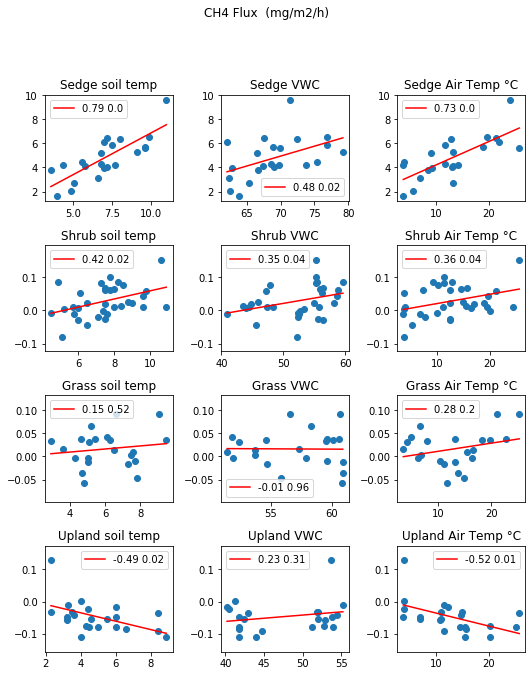

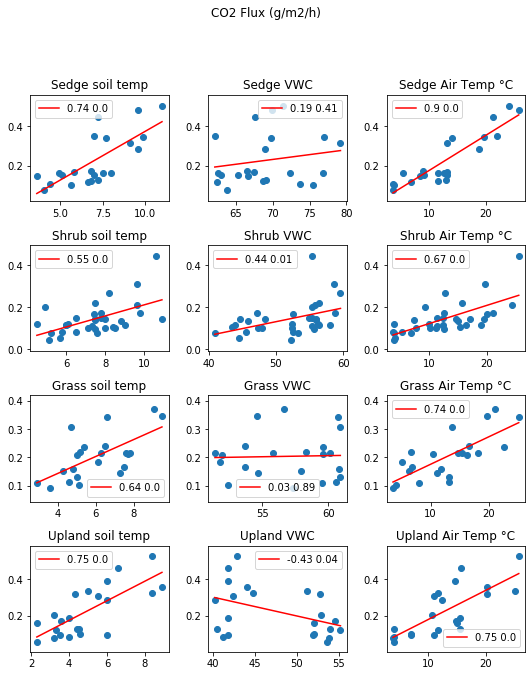

In [4]:
from matplotlib import pyplot as plt

def Plot(ax1,ax2,ax3,Class,Collar='veg'):
    Bukey = CD.reset_index()
    Tukey = Bukey.loc[(Bukey['Class']==Class) & (Bukey['Collar']==Collar)]
    Regressor='soil temp'
    MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
    slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
    ax1.scatter(Tukey[Regressor],Tukey[flux])
    ax1.plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
    ax1.set_title(Class+' '+ Regressor)
    ax1.legend()
    Regressor='VWC'
    MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
    slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
    ax2.scatter(Tukey[Regressor],Tukey[flux])
    ax2.plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
    ax2.set_title(Class+' '+ Regressor)
    ax2.legend()
    Regressor = 'Air Temp °C'
    MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
    slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
    ax3.scatter(Tukey[Regressor],Tukey[flux])
    ax3.plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
    ax3.set_title(Class+' '+ Regressor)
    ax3.legend()
#     print(flux)
    

for flux in ['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']:
    
    fig,ax=plt.subplots(4,3,figsize = (7.5,8.5))
#     i=0
    for i,Class in enumerate(['Sedge','Shrub','Grass','Upland']):
        Plot(ax[i,0],ax[i,1],ax[i,2],Class)
#     Plot(ax[4,0],ax[4,1],Class = 'Sparse',Collar='unveg')
    
#     Tukey = Bukey.loc[Bukey['Class']=='Upland']
#     Regressor='soil temp'
#     MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
#     slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
# #     print(slope, intercept, r_value, p_value, std_err)
# #     ax[0,1].figure()
#     ax[1,0].scatter(Tukey[Regressor],Tukey[flux])
#     ax[1,0].plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
#     ax[1,0].set_title('Upland '+' '+ Regressor)
#     ax[1,0].legend()
#     Regressor='VWC'
#     MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
#     slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
# #     print(slope, intercept, r_value, p_value, std_err)
# #     ax[1,1].figure()
#     ax[1,0].scatter(Tukey[Regressor],Tukey[flux])
#     ax[1,0].plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
#     ax[1,0].set_title('Upland '+' '+ Regressor)
#     ax[1,0].legend()
#     print(flux)
    
#     Tukey = Bukey.loc[Bukey['Class']=='Shrub']
#     Regressor='soil temp'
#     MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
#     slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
# #     print(slope, intercept, r_value, p_value, std_err)
# #     ax[2,0].figure()
#     ax[2,0].scatter(Tukey[Regressor],Tukey[flux])
#     ax[2,0].plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
#     ax[2,0].set_title('Shrub '+' '+ Regressor)
#     ax[2,0].legend()
#     Regressor='VWC'
#     MxMn = np.array([Tukey[Regressor].min(),Tukey[Regressor].max()])
#     slope, intercept, r_value, p_value, std_err = stats.linregress(Tukey[Regressor],Tukey[flux])
# #     print(slope, intercept, r_value, p_value, std_err)
# #     ax[2,1].figure()
#     ax[2,1].scatter(Tukey[Regressor],Tukey[flux])
#     ax[2,1].plot(MxMn,MxMn*slope+intercept,label=str(np.round(r_value,2))+' '+str(np.round(p_value,2)),color='red')
#     ax[2,1].set_title('Shrub '+' '+ Regressor)
#     ax[2,1].legend()
    plt.suptitle(flux,y=1.1)
#     print(flux)
    plt.tight_layout(pad = 1.1)
#     print()
#     print()
#     Tukey = Tukey.loc[((Tukey['Collar']=='veg')|(Tukey['Class']=='Sparse'))]
#     from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
#                                              MultiComparison)
#     if flux == 'CH4 Flux  (mg/m2/h)':
#         Tukey = Tukey.loc[Tukey['Class']!='Sedge']

#     # Set up the data for comparison (creates a specialised object)
#     MultiComp = MultiComparison(Tukey[Flux],
#                                 Tukey['Class'])

#     # Show all pair-wise comparisons:

#     # Print the comparisons
#     results = MultiComp.tukeyhsd()

#     print(MultiComp.tukeyhsd().summary())
#     results.plot_simultaneous()
    
# CI=(CDStd/(CDC)**.5*stats.t.ppf(1-.05,CDC))
# print(CI[['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']].unstack())
# print(CDMean[['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']].unstack())
# (CD.reset_index()['datetime']).to_csv('C:\\Users\\wesle\\NetworkAnalysis/ChamberDates.csv')
# print(Dates.dt.dayofyear)

# print(TAmp['Weighted']*24)
# print(CD.reset_index())
# print(Temp)

In [14]:
import statsmodels.api as sm
Y = np.array([1,3,4,5,5,6,7])
X = np.array([range(1,8),range(2,9)]).T
# X = np.array(range(1,8))
X = sm.add_constant(X)
print(X.shape,Y.shape)
model = sm.OLS(Y,X)
Res = results = model.fit()
# results.params
Res.summary()

(7, 3) (7,)


C:\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     80.13
Date:                Sat, 09 Nov 2019   Prob (F-statistic):           0.000290
Time:                        16:11:01   Log-Likelihood:                -4.2816
No. Observations:                   7   AIC:                             12.56
Df Residuals:                       5   BIC:                             12.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2738      0.327      0.836      0.441      -0.568       1.116
x1             0.3095      0.210      1.472      0.201      -0.231       0.850
x2             0.5833      0.120      4.866      0.005       0.275       0.891
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.485
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.475
Skew:                          -0.216   Prob(JB):                        0.789
Kurtosis:                       1.799   Cond. No.                     3.26e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.28e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

CO2 Flux (g/m2/h) Shrub
83.74398818164362 13.245370112866512
CO2 Flux (g/m2/h) Grass
117.27946983167999 17.094001492932364
CO2 Flux (g/m2/h) Sparse
46.95344785361455 7.240758561942064
CO2 Flux (g/m2/h) Upland
128.44387581905454 28.652104543540826
CO2 Flux (g/m2/h) Sedge
130.97064058926546 27.81093971896943

CH4 Flux  (mg/m2/h) Shrub
16.00661708823273 8.030605436169104
CH4 Flux  (mg/m2/h) Grass
9.311218743272727 8.249130607377833
CH4 Flux  (mg/m2/h) Sparse
0.6316911925527253 13.924218772796115
CH4 Flux  (mg/m2/h) Upland
-26.931780413672733 10.54055928194494
CH4 Flux  (mg/m2/h) Sedge
2753.7422835005664 367.6914265723734



<Figure size 720x720 with 0 Axes>

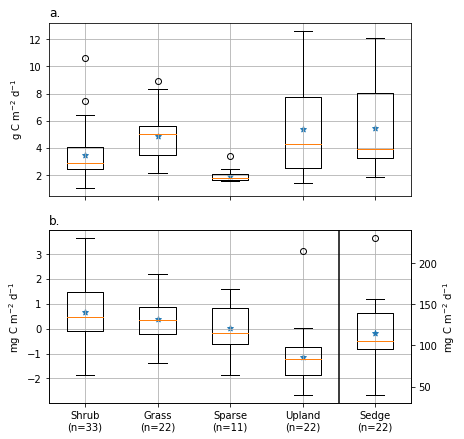

In [6]:
fig = plt.figure(figsize = (10,10))
Flux = 'CH4 Flux  (nmol/m2/s)'
Flux = 'CO2 Flux (umol/m2/s)'
Flux = 'CO2 Flux (g/m2/h)'
mult = 24
fig,axes = plt.subplots(2,figsize=(6.5,7))
j=-1
Order = ['Shrub','Grass','Sparse','Upland','Sedge']
Title ={'CH4 Flux  (mg/m2/h)':'b.','CO2 Flux (g/m2/h)':'a.'}
for Flux in ['CO2 Flux (g/m2/h)','CH4 Flux  (mg/m2/h)']:
    i = 0
    j+=1
    ax=axes[j]
    Data=[]
    Means = []
    Counts = []
    Medians = []
    AltData=[]
    AltMeans = []
    AltMedians = []
    CI = []
    for Class in Order:
        if Class == 'Sedge' and Flux == 'CH4 Flux  (mg/m2/h)':
            Data.append([])
            Means.append(np.nan)
            Medians.append(np.nan)
            i +=1
            Temp = (CD.loc[(CD.index.get_level_values('Collar') =='veg') & \
                         (CD.index.get_level_values('Class') == Class)][Flux]).\
                        reset_index('datetime').sort_values('datetime').reset_index(drop=True)
            TOmp = (CD.loc[(CD.index.get_level_values('Collar') =='unveg') & \
                         (CD.index.get_level_values('Class') == Class)][Flux]).\
                        reset_index('datetime').sort_values('datetime').reset_index(drop=True)

            if Class == 'Sparse':
                Temp = TOmp
            Temp[Flux] = Temp[Flux].fillna(TOmp[Flux])
            V = Temp[Flux]*mult
            P = Temp['datetime']
            AltData.append(V.values)
            AltMeans.append(V.mean())
            AltMedians.append(V.median())
            Myax = V.max()
            Myin = V.min()
            Counts.append(V.count())
            CI.append(V.std())
        else:
            AltData.append([])
            AltMeans.append(np.nan)
            AltMedians.append(np.nan)
            i +=1
            Temp = (CD.loc[(CD.index.get_level_values('Collar') =='veg') & \
                         (CD.index.get_level_values('Class') == Class)][Flux]).\
                        reset_index('datetime').sort_values('datetime').reset_index(drop=True)
            TOmp = (CD.loc[(CD.index.get_level_values('Collar') =='unveg') & \
                         (CD.index.get_level_values('Class') == Class)][Flux]).\
                        reset_index('datetime').sort_values('datetime').reset_index(drop=True)

            if Class == 'Sparse':
                Temp = TOmp
            Temp[Flux] = Temp[Flux].fillna(TOmp[Flux])
            V = Temp[Flux]*mult
            P = Temp['datetime']
            Data.append(V.values)
            Means.append(V.mean())
            Counts.append(V.count())
            Medians.append(V.median())
            CI.append(V.std())
        
        print(Flux,Class)
        print(V.mean()*24,V.std()*1/(V.count()**.5)*stats.t.ppf(1-.05,V.count())*24)
    
    CI = np.asanyarray(CI)
    Counts = np.asanyarray(Counts)
    ax.boxplot(Data)
#     print(Order)
    Labs = [C+'\n(n='+str(i)+')' for C,i in zip(Order,Counts)]
    if Flux == 'CH4 Flux  (mg/m2/h)':
        ax2 = ax.twinx()
        ax2.boxplot(AltData)
        ax2.scatter([i+1 for i in range(len(AltMeans))],AltMeans,marker = '*')
        Ylbl = 'mg C m$^{-2}$ d$^{-1}$'
    else:
        
        Ylbl = 'g C m$^{-2}$ d$^{-1}$'
        
    ax.set_xticks([i+1 for i in range(len(Means))])

    ax.scatter([i+1 for i in range(len(Means))],Means,marker = '*')
    ax.set_ylabel(Ylbl)

    Temp = (CD.loc[(CD.index.get_level_values('Collar') =='veg') & \
                     (CD.index.get_level_values('Class') == Class)]['CO2 Flux (umol/m2/s)']).reset_index(level = ['Class','Collar'],drop=True)#\
    ax.set_title(Title[Flux],loc='left')
    if Flux == 'CH4 Flux  (mg/m2/h)':
        ax2.set_ylabel(Ylbl)
        ax.set_xticklabels(Labs)
#         print(Yl)
        
        Means[-1]=AltMeans[-1]
        Medians[-1]=AltMedians[-1]
#         ax.set_ylim(-3.5,5.5)
#         ax2.set_ylim(12.5,237.56)
#         ax2.set_yticks([0,75,150,225,300])
        Yl = ax.get_ylim()
        ax.set_ylim(Yl[0],Yl[1])
        ax.plot([i-.5,i-.5],[Yl[0],Yl[1]],color='black')
    else:
        ax.set_xticklabels(['' for l in Labs])
#     print(Means*24)#,Medians)
    
#     print(CI)
    CI = CI/Counts**.5*stats.t.ppf(1-0.025,Counts)
#     print(CI*24)
    print()
    ax.grid()
#     print(np.asanyarray(Means).mean())
#     print(np.asanyarray(Means).std()/5**.5*stats.t.ppf(1-0.025,5))
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi = 300)

In [71]:

#        'C3' : 'Low Willow',
#        'E2' : 'Dense Willow',
#        'F8' : 'Tall Willow',


Temp = CD.reset_index().groupby(['Site','Collar']).median()
# print(Temp)
print(Temp.loc[Temp.index.get_level_values('Site')=='F8','CO2 Flux (umol/m2/s)'])
print(Temp.loc[Temp.index.get_level_values('Site')=='E2','CO2 Flux (umol/m2/s)'])
print(Temp.loc[Temp.index.get_level_values('Site')=='C3','CO2 Flux (umol/m2/s)'])#.groupby(['Site','Collar']).mean())
# for C in ['Sedge','Grass','Shrub','Upland']:
#     T = (CD.loc[CD.index.get_level_values('Class')==C,['VWC','soil temp','CH4 Flux  (mg/m2/h)']].reset_index([0,1]))
#     T = T.groupby(T.index.dayofyear).mean()
#     fig,ax = plt.subplots(2,1)
#     print(C)
#     ax[0].plot(T['VWC'])
#     ax[1].plot(T['soil temp'])
#     ax[0].set_title('VWC'+ '  '+C)
#     ax[1].set_title('soil temp')
#     plt.tight_layout()
#     plt.suptitle(C,loc='left')
#     plt.figure()
#     plt.plot(T['CH4 Flux  (mg/m2/h)'])

Site  Collar
F8    unveg     1.930769
      veg       2.610909
Name: CO2 Flux (umol/m2/s), dtype: float64
Site  Collar
E2    unveg     2.458231
      veg       2.804727
Name: CO2 Flux (umol/m2/s), dtype: float64
Site  Collar
C3    unveg     3.012538
      veg       4.671818
Name: CO2 Flux (umol/m2/s), dtype: float64


In [1209]:


# for Flux in ['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']:
#     print()
#     print(Flux)
#     D = []
#     idx = []
#     for Regressor in ['VWC','Press    Pa','soil temp','Air Temp °C']:
#         for Class in CD.index.get_level_values('Class').unique():
#             if Class != 'Sparse':
#                 Klass = CD.loc[(CD.index.get_level_values('Class')==Class)&\
#                            (CD.index.get_level_values('Collar')=='veg')].reset_index()
#             else:
#                 Klass = CD.loc[(CD.index.get_level_values('Class')==Class)&\
#                            (CD.index.get_level_values('Collar')=='unveg')].reset_index()
#             Klass[Regressor]=Klass[Regressor].astype(float)
#             slope, intercept, r_value, p_value, std_err = stats.linregress(Klass[Regressor],Klass[Flux])
#             if p_value < .1 and r_value**2>0.5:
#                 fig,ax = plt.subplots()
#                 ax.set_title(Regressor)
#                 ax.set_ylabel(Flux)
#                 Range = np.arange(Klass[Regressor].min(),Klass[Regressor].max())
# #                 plt.plot()
#                 ax.plot(Range,Range*slope+intercept,label = np.round(r_value,2))
#                 ax.scatter(Klass[Regressor],Klass[Flux],label=Class)
#                 d = [Regressor,p_value,r_value,r_value**2]
#                 D.append(d)
#                 idx.append(Class)
#                 ax.legend()
#             if Regressor == 'Air Temp °C':
#                 Temp = 9.77
#                 MSE = (metrics.mean_squared_error(Klass[Flux],Klass[Regressor]*slope+intercept))
#                 N = Klass[Flux].count()
#                 SE = (MSE*(1/N+((Temp-Klass[Regressor].mean())**2)/\
#                           ((Klass[Regressor]-Klass[Regressor].mean())**2).sum()))**.5
#                 T = stats.t.ppf(1-0.025,N)
#                 PI = SE*T
# #                 print()
# #                 print(Class,slope*Temp+intercept,PI)
            
# #             except:
# #                 pass

#     Scores = pd.DataFrame(data=D,index=idx,columns=['Regressor','p','r','r^2'])
#     print(Scores)

# CDmax=CDmax.convert_objects(convert_numeric=True)
# CDmin=CDmin.convert_objects(convert_numeric=True)
# CDMean=CDMean.convert_objects(convert_numeric=True)
# CDStd=CDStd.convert_objects(convert_numeric=True)

# fig,ax=plt.subplots()
# print(CDmax.unstack()['VWC']-CDmin.unstack()['VWC'])
# CDmax.unstack()['VWC']['veg'].plot.bar(color='blue',ax=ax)
# CDmin.unstack()['VWC']['veg'].plot.bar(color='white',ax=ax)
# ax.set_ylim(40,80)

# fig,ax=plt.subplots()
# print('co2')
# print(CDmax.unstack()['CO2 Flux (g/m2/h)'])
# print()
# print(CDmin.unstack()['CO2 Flux (g/m2/h)'])
# CDmax.unstack()['soil temp']['veg'].plot.bar(color='brown',ax=ax)
# CDmin.unstack()['soil temp']['veg'].plot.bar(color='white',ax=ax)


# fig,ax=plt.subplots()
# print()

# print('ch4')
# print(CDmax.unstack()['CH4 Flux  (mg/m2/h)'])
# print()
# print(CDmin.unstack()['CH4 Flux  (mg/m2/h)'])
# CDmax.unstack()['Air Temp °C']['veg'].plot.bar(color='red',ax=ax)
# CDmin.unstack()['Air Temp °C']['veg'].plot.bar(color='white',ax=ax)

# print()
# print('max',CDMax.unstack()[[,'CO2 Flux (g/m2/h)']]['veg'].mean())
# # print('min',CDMin.unstack()[['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']]['veg'].mean())

In [881]:

# import matplotlib.gridspec as gridspec
# fig,ax = plt.subplots(2,1,figsize= (6.5,7.5))


In [627]:
# Flux = 'CH4 Flux  (mg/m2/h)'
# Flux = 'CO2 Flux (g/m2/h)'
# Temp = Temp.replace({'W':Fractions['aea']})
# print(Temp)

In [ ]:

#     print(M*mult,(S/C**.5)*stats.t.ppf(1-0.25,C.values)*mult,[Fractions['area'][v] for v in M.index.values])
    
#     M = CDMean[Flux].unstack().reset_index()
#     C = CDC[Flux].unstack().reset_index()
#     S = CDStd[Flux].unstack().reset_index()
    
#     if Flux == 'CH4 Flux  (mg/m2/h)':
#         inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                         subplot_spec=outer[1], wspace=0.1, hspace=0.05)

#         ax0 = plt.Subplot(fig, inner[1])
#         ax1 = plt.Subplot(fig, inner[0])
#         ax1.spines['bottom'].set_visible(False)
#         ax0.spines['top'].set_visible(False)
#         ax1.xaxis.tick_top()
#         ax1.tick_params(labeltop='off')  # don't put tick labels at the top
#         ax0.xaxis.tick_bottom()
#         N=C['veg']
        
#         ax0.bar(M.index,M['veg'],width=.45,
#                 yerr=S['veg']**.5/C['veg']*1.96,color='green')
#         ax0.bar(M.index+.45,M['unveg'],width=.45,
#                 yerr=S['unveg']**.5/C['unveg']*1.96,color='brown')
        
# #         ax0.bar(M.index,M['veg'],width=.45,yerr=S['veg'],color='green')#*stats.t.ppf(1-0.025, N)
# #         ax0.bar(M.index+.45,M['unveg'],width=.45,yerr=S['unveg'],color='brown')#*stats.t.ppf(1-0.025, N)
#         ax0.set_ylim(-.11,.25)
#         ax0.grid()
# #         print(M['veg'])
# #         print(S['veg'])#*stats.t.ppf(1-0.025, N))
#         L = ['']
#         for v in M.Class.values:
#             L.append(v)
#         ax0.set_xticklabels(L,rotation=90)
# #         ax0.set_yscale('symlog')
#         ax1.bar(M.index,M['veg'],width=.45,
#                 yerr=S['veg']**.5/C['veg']**.5*stats.t.ppf(1-0.25,C['veg']),color='green')
#         ax1.bar(M.index+.45,M['unveg'],width=.45,
#                 yerr=S['unveg']**.5/C['unveg']**.5*stats.t.ppf(1-0.25,C['unveg']),color='brown')
#         ax1.set_ylim(3.45,7.5)
#         ax1.grid()
#         ax1.set_title('NME')# $(mg m^{-2} s^{-1})$')
#         d = .01  # how big to make the diagonal lines in axes coordinates
#         kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#         ax1.plot((-d, +d), (-d, +d), **kwargs)     
#         ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

#         kwargs.update(transform=ax0.transAxes)  
#         ax0.plot((-d, +d), (1 - d, 1 + d), **kwargs)
#         ax = plt.Subplot(fig, outer[1])
#         ax.axes.get_xaxis().set_visible(False)
# #         yl = ax.axes.get_yticks()
# #         print(yl)
#         ax.axes.set_yticks([0,1])
#         ax.axes.set_yticklabels(['    ','    '])
# #         ax.axes.get_yaxis().set_visible(False)
#         ax.set_ylabel('${mg m^{-2} h^{-1}}$')
#         fig.add_subplot(ax)
# #         plt.sca(ax)
# #         plt.axis('off')
#         ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
#         fig.add_subplot(ax0)
#         fig.add_subplot(ax1)
#     else:
#         ax = plt.Subplot(fig, outer[0])
# #         ax.bar(M.index,M['veg'],width=.45,
# #                yerr=S['veg'],color='green')#*stats.t.ppf(1-0.25,C['veg'])
# #         ax.bar(M.index+.45,M['unveg'],width=.45,
# #                yerr=S['unveg'],color='brown')#*stats.t.ppf(1-0.25,C['unveg'])
# #         ax.grid()
# #         ax.boxplot(M.index,M['veg'])
#         M.boxplot()
#         ax.tick_params(labelbottom='off')
# #         print(M)
#         ax.set_title('ER')# $(g m^{-2} s^{-1})$')
#         ax.set_ylabel('${g m^{-2} h^{-1}}$')
#         fig.add_subplot(ax)
        
#     plt.savefig('Fig2.png',dpi = 300)
    
    
    #**.5#/C*stats.t.ppf(1-0.025,C)
#     print(M.index)
#     print(CDMean[Flux].unstack()['veg'])
#     CDMean[Flux].unstack().plot.bar(stacked=False,yerr=CDStd[Flux].unstack(),ax=ax[i])

N = 5


# for Flux in ['CH4 Flux  (mg/m2/h)','CO2 Flux (g/m2/h)']:
#     print('Scaled Flux: ',Flux,Fractions[Flux].sum(),)
#     print(Fractions[Flux+' std'].sum()**.5/(N**.5)*stats.t.ppf(1-0.025, N))
# #     print(CDStd[Flux])
# #     print(Fractions[Flux+' std'].sum(),)
# # plt.show()
# print(Fractions[Flux])


# print(CD['CO2 Flux (g/m2/h)'])
# print(CD.groupby([level_values(i) for i in [1,0,2]]).mean()['CO2 Flux (g/m2/h)'].unstack(1)['Shrub']\
#       .unstack(0)['veg'].mean())#['veg'].mean())
# plt.scatter(CD['CO2 Flux (g/m2/h)'])
# print(CDMean['CO2 Flux (g/m2/h)'])


#### # Flux = 'CH4 Flux  (mg/m2/h)'
Flux = 'CO2 Flux (g/m2/h)'

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

CD2 = CD.swaplevel(i=0,j=1).loc['unveg'].reset_index()
# CD2 = CD2.loc[CD2['Class']!='Sedge']
Mean = CD2.groupby('Class').mean()
Mean['SEM'] = CD2.groupby('Class')[Flux].sem()*stats.t.ppf(1-0.025, CD2.groupby('Class')[Flux].count())
print(Mean[[Flux,'SEM']].round(2))

# CD2 = CD.swaplevel(i=0,j=1).loc['unveg'].reset_index()
# # CD2 = CD2.loc[CD2['Class']!='Sedge']
MeanV = CD2.groupby('Class').mean()
# MeanV['SEM'] = CD2.groupby('Class')[Flux].sem()*stats.t.ppf(1-0.025, CD2.groupby('Class')[Flux].count())
# print(MeanV[[Flux,'SEM']].round(2))

print(((Mean[Flux]-MeanV[Flux])/Mean[Flux]*100).round(2))

mc = MultiComparison(CD2[Flux], CD2['Class'])
print(CD2[Flux].shape)
result = mc.tukeyhsd(alpha=.05)
 
# print(mc.groupsunique)
result.plot_simultaneous()
print(result)
# print(CD)
# print(result.meandiffs)